In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from collections import defaultdict

sns.set_theme(palette="bright", style="whitegrid")
matplotlib.rcParams['font.serif'] = "cmb10"
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True

In [30]:
color_mapping = {
    k: v for k, v in zip(
        ["CBL-1", "Bufboss-1", "Bifrost-1", "BSBWT-1-0.5", "BSBWT-4-0.5", "BSBWT-16-4.0", "Bifrost-32", "BSBWT-32-30.0"],
        sns.color_palette())
}
name_mapping = {
 k: v for k, v in zip(
        ["CBL-1", "Bufboss-1", "Bifrost-1", "BSBWT-1-0.5", "BSBWT-4-0.5", "BSBWT-16-4.0", "Bifrost-32", "BSBWT-32-30.0"],
        ["CBL",  "Bufboss",   "Bifrost 1t", "DSBWT 1t 0.5G", "DSBWT 4t 0.5G", "DSBWT 16t 4G", "Bifrost 32t", "DSBWT 32t 30G"])
}
IO_name_mapping = {
 k: v for k, v in zip(
        ["CBL-1", "Bufboss-1", "Bifrost-1", "BSBWT-1-0.5", "BSBWT-4-0.5", "BSBWT-16-4.0", "Bifrost-32", "BSBWT-32-30.0"],
        ["CBL",  "Bufboss",   "Bifrost", "DSBWT", "nope", "nope", "nope", "nope"])
}
marker_mapping = {
 k: v for k, v in zip(
        ["CBL-1", "Bufboss-1", "Bifrost-1", "BSBWT-1-0.5", "BSBWT-4-0.5", "BSBWT-16-4.0", "Bifrost-32", "BSBWT-32-30.0"],
        ["o", "X", "s", "^", ">", "<", "d", "v"])
}  

In [31]:
def read_res(path):
    data = defaultdict(list)
    sizes = []
    added = []
    offered = []
    time = 0
    insertion_time = 0
    serialization_time = 0
    deserialization_time = 0
    rss = 0
    ds_type = None
    threads = 0
    file_count = 0
    buf_size = 0
    with open(path) as in_f:
        for line in in_f:
            if "CBL/target/release" in line:
                ds_type = "CBL"
                threads = 1
            elif "bufboss/bin/" in line:
                ds_type = "Bufboss"
                threads = 1
            elif "bifrost/build/bin" in line:
                ds_type = "Bifrost"
            elif "Buffered_SBWT" in line:
                ds_type = "BSBWT"
            elif line.startswith("threads = "):
                threads = int(line.split()[-1])
            elif line.startswith("max buffer size"):
                buf_size = float(line.split()[-2])
            elif line.startswith("# Insertion time"):
                insertion_time = int(line.split()[-1])
                insertion_time /= 1000000000
            elif line.startswith("# Serialization time"):
                serialization_time = int(line.split()[-1])
                serialization_time /= 1000000000
            elif line.startswith("Insert time"):
                insertion_time = int(line.split()[-1])
                insertion_time /= 1000000000
            elif line.startswith("Serialization time"):
                serialization_time = int(line.split()[-1])
                serialization_time /= 1000000000
            elif "loaded in" in line:
                deserialization_time = float(line.split()[-2]) / 1000
            elif line.startswith("Wrote"):
                serialization_time = float(line.split()[-2]) / 1000
            elif "Loaded BOSS" in line:
                deserialization_time = float(line.split()[0])
            elif "Merged BOSS" in line:
                insertion_time = float(line.split()[0])
            elif line.endswith("Done\n"):
                serialization_time = float(line.split()[0]) - insertion_time
                insertion_time -= deserialization_time
            elif "maxresident" in line:
                for field in line.split():
                    if "elapsed" in field:
                        f_s = field[:-7].split(':')
                        time = int(f_s[-2]) * 60 + float(f_s[-1])
                        if len(f_s) > 2:
                            time += int(f_s[0]) * 60 * 60
                    elif "maxresident" in field:
                        rss = int(field[:-13])
                        rss /= 1024
                        if ds_type == "BSBWT":
                            label = f"{ds_type}-{threads}-{buf_size}"
                        elif ds_type == "Bufboss":
                            label = f"{ds_type}-{threads}"
                        else:
                            label = f"{ds_type}-{threads}"
                            deserialization_time = time - serialization_time - insertion_time
                        data[label].append((time, rss, deserialization_time, insertion_time, serialization_time))
            elif threads == 1 and line.startswith("Saw "):
                elems = int(line.split()[1]) // 2
                offered.append(elems)
            elif threads == 1 and line.startswith("Added"):
                ss = line.split()
                elems = int(ss[1]) // 2
                insertion_time = float(ss[-2]) / 1000
                added.append(elems)
            elif line.startswith("Added"):
                insertion_time = float(line.split()[-2]) / 1000
            elif threads == 1 and "with " in line and "31-mers" in line:
                elems = int(line.split()[1]) // 2
                sizes.append(elems)
    return {
        "offered": offered,
        "size": sizes,
        "added": added, 
        "data": data
    }

In [32]:
def plot_time_and_space(res, title, name=None, key=0, lab="Insertion time", deserialize=True):
    size = res["size"] if deserialize else [s + a for s, a in zip(res["size"], res["added"])]
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[key] for vv in v], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel(f"{lab} (s)")
    plt.legend()
    plt.title(lab)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(1, 2, 2)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[1] for vv in v], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("RSS (M)")
    plt.legend()
    plt.title("Total Memory")
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.suptitle(title)
    if name is not None:
        plt.savefig(name, bbox_inches="tight")
    plt.show()

In [33]:
def plot_time_and_space_per_kmer(res, div, title, name=None, key=0, lab="Insertion time"):
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[key] * 1000**3 / s for vv, s in zip(v, div)], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel(f"{lab} ns / k-mer")
    plt.legend()
    plt.title(lab)
    #a, b = plt.ylim()
    #plt.ylim(10, b)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(1, 2, 2)
    for k, v in res["data"].items():
        plt.plot(res["size"], [vv[1] * 1024**2 * 8 / s for vv, s in zip(v, res["size"])], label=k, marker="^")
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Index size (k-mers)")
    plt.ylabel("RSS bits / k-mer")
    plt.legend()
    plt.title("memory efficiency")
    a, b = plt.ylim()
    plt.ylim(10, b)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.suptitle(title)
    if name is not None:
        plt.savefig(name, bbox_inches="tight")
    plt.show()

In [34]:
coli_ins = read_res("../bbb_res/insert_coli.txt")

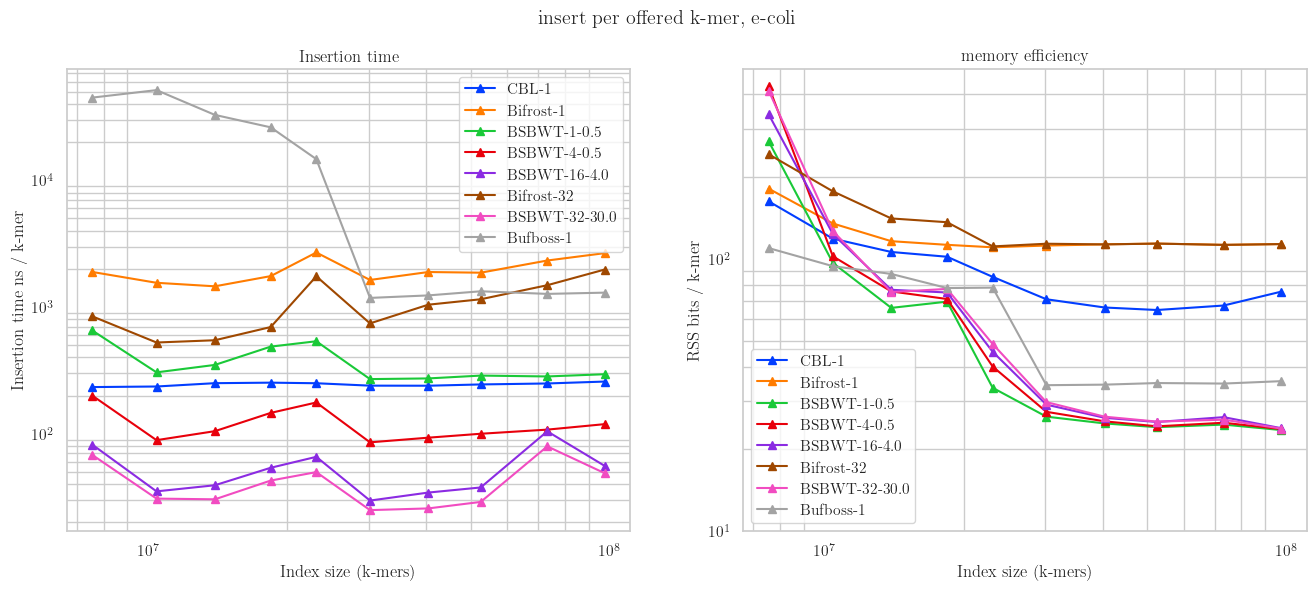

In [35]:
plot_time_and_space_per_kmer(coli_ins, coli_ins["offered"], "insert per offered k-mer, e-coli", "insert_e-coli_per_offered_kmer.pdf", 3)

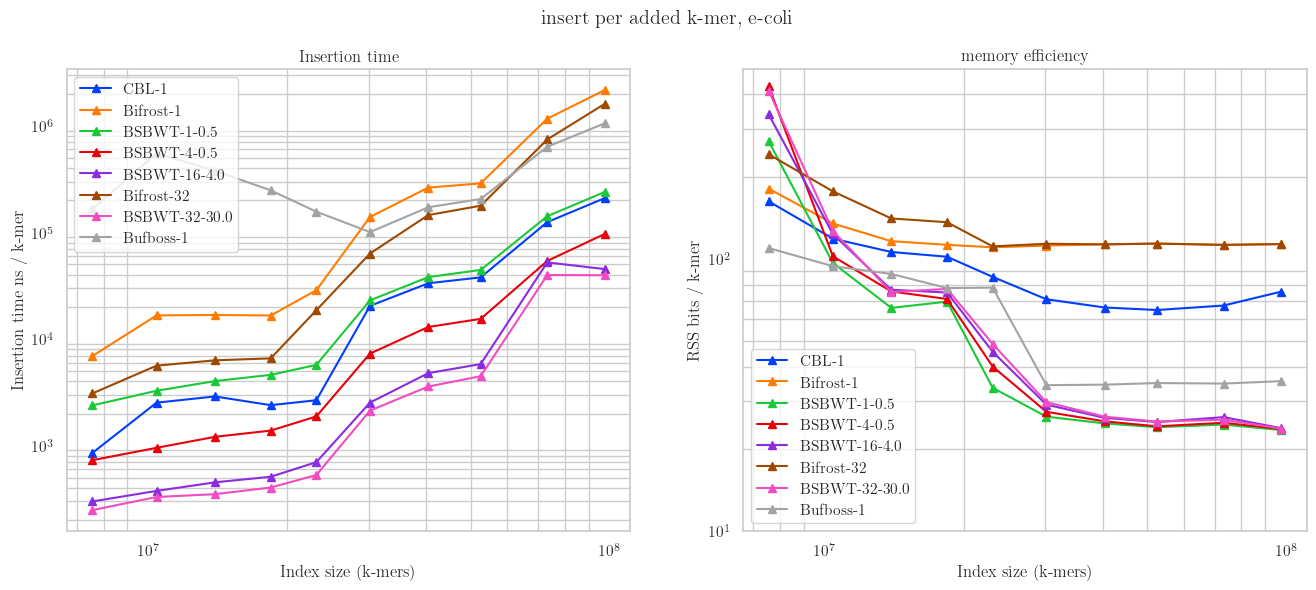

In [36]:
plot_time_and_space_per_kmer(coli_ins, coli_ins["added"], "insert per added k-mer, e-coli", "insert_e-coli_per_added_kmer.pdf", 3)

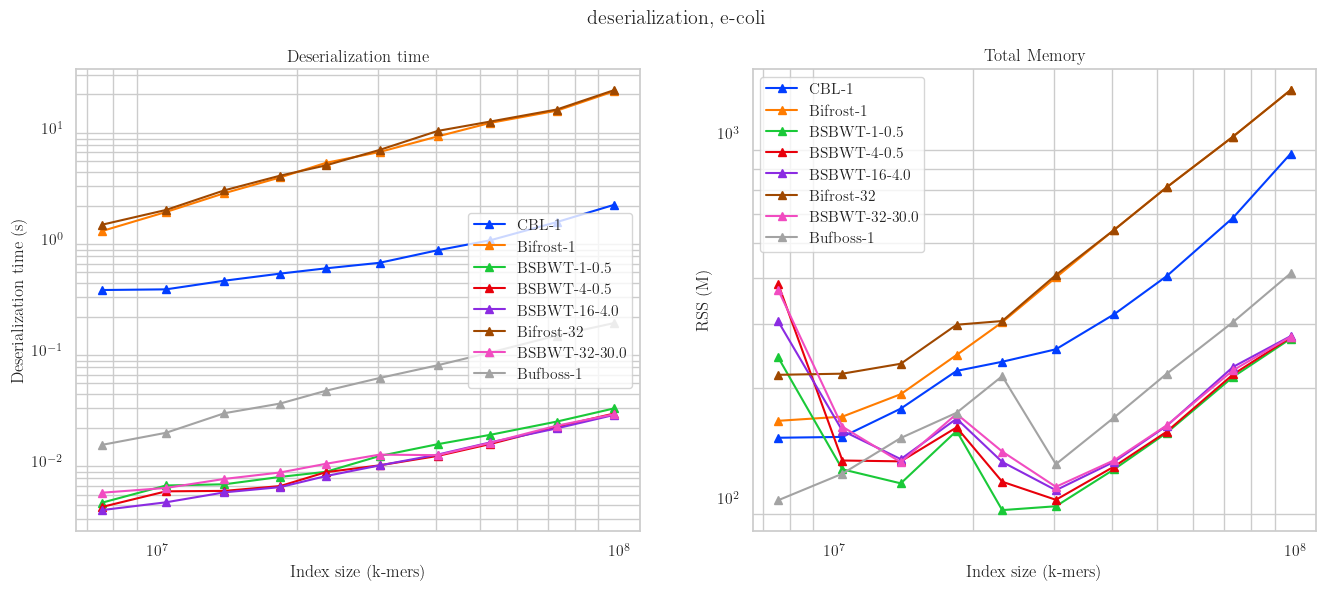

In [37]:
plot_time_and_space(coli_ins, "deserialization, e-coli", "deserialization_e-coli_total.pdf", 2, "Deserialization time")

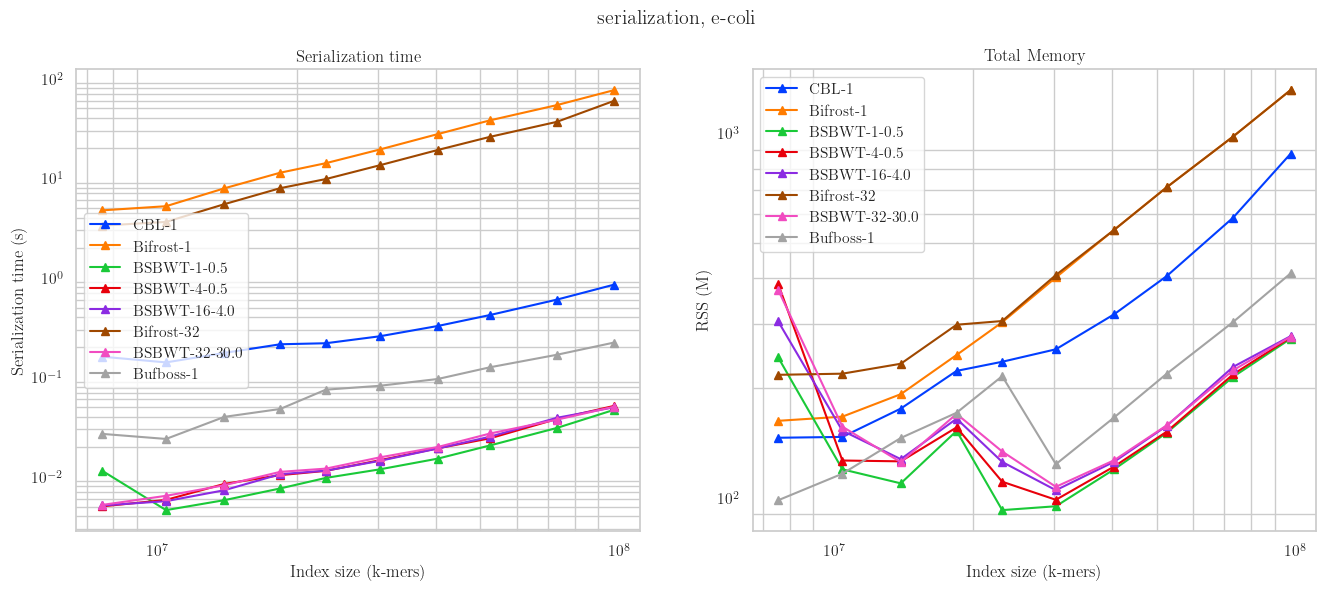

In [38]:
plot_time_and_space(coli_ins, "serialization, e-coli", "serialization_e-coli_total.pdf", 4, "Serialization time", False)

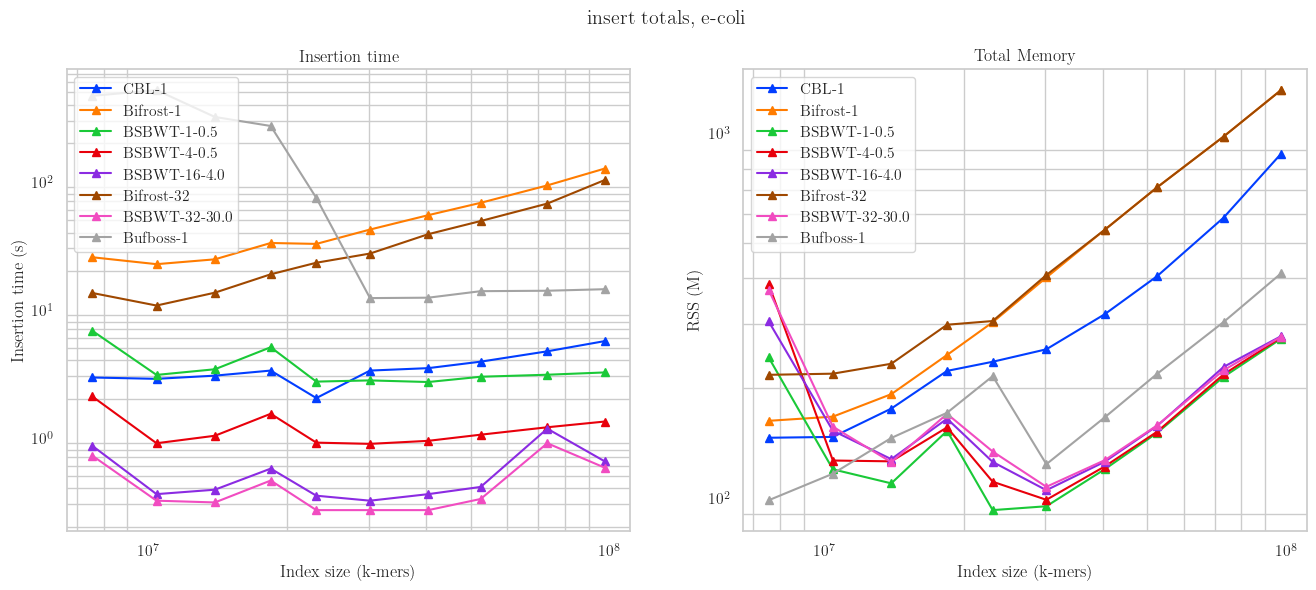

In [39]:
plot_time_and_space(coli_ins, "insert totals, e-coli", "insert_e-coli_total.pdf")

In [40]:
bact_ins = read_res("../bbb_res/insert_bact.txt")

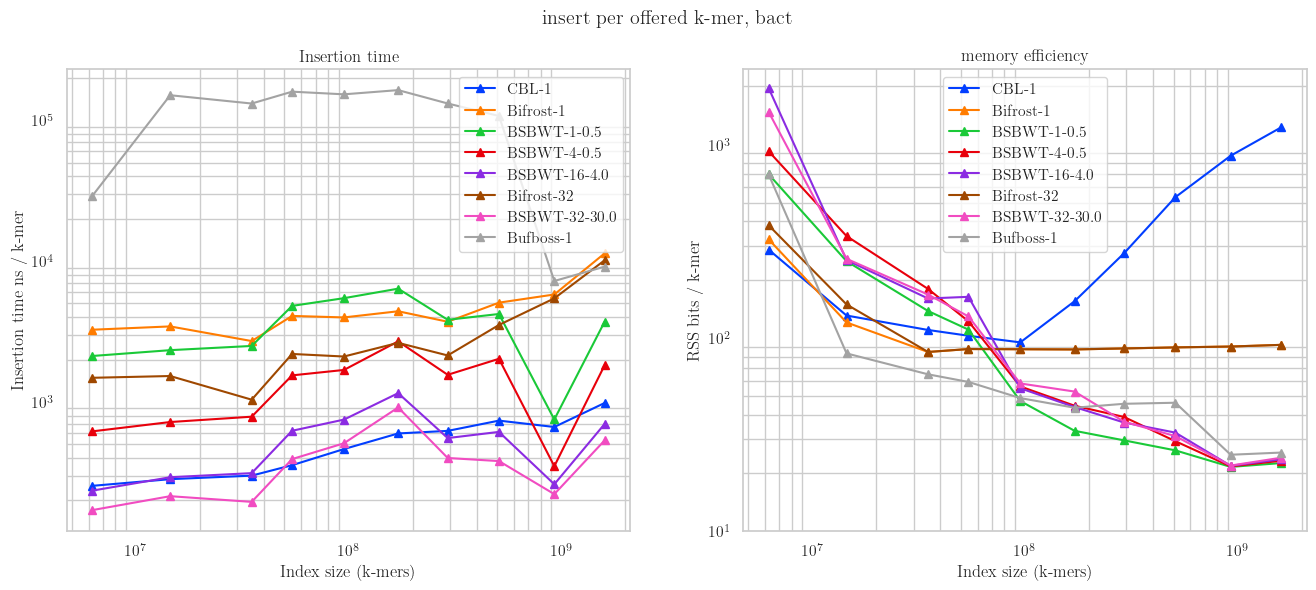

In [41]:
plot_time_and_space_per_kmer(bact_ins, bact_ins["offered"], "insert per offered k-mer, bact", "insert_bact_per_offered_kmer.pdf", 3)

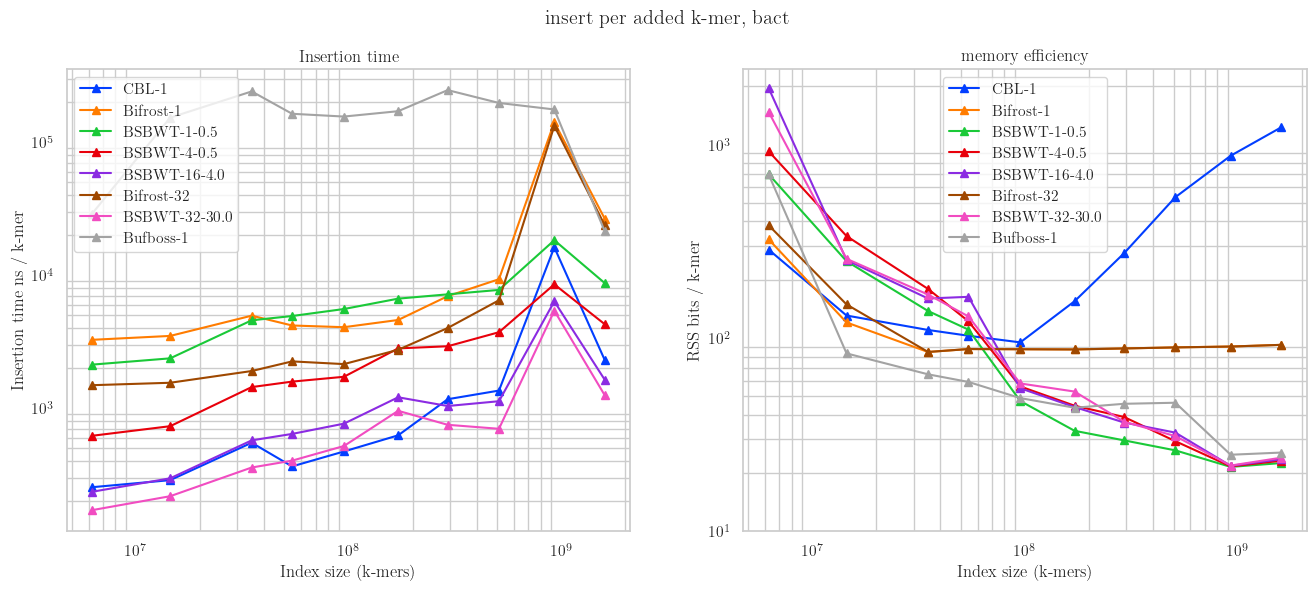

In [42]:
plot_time_and_space_per_kmer(bact_ins, bact_ins["added"], "insert per added k-mer, bact", "insert_bact_per_added_kmer.pdf", 3)

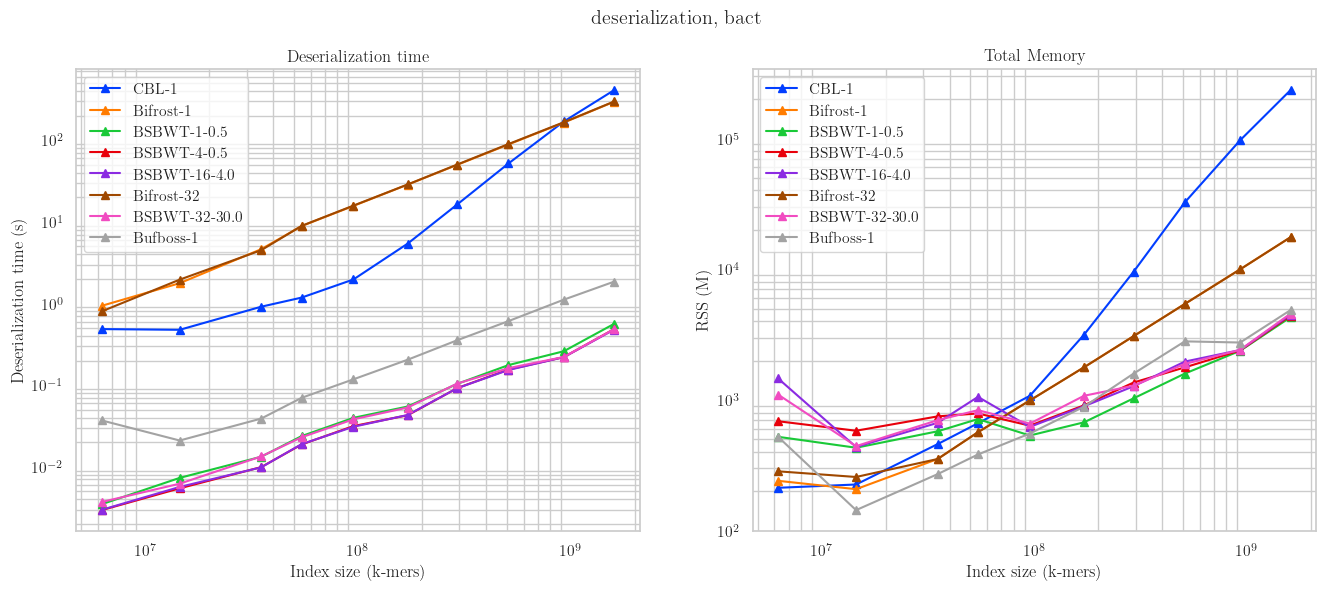

In [43]:
plot_time_and_space(bact_ins, "deserialization, bact", "deserialization_bact_total.pdf", 2, "Deserialization time")

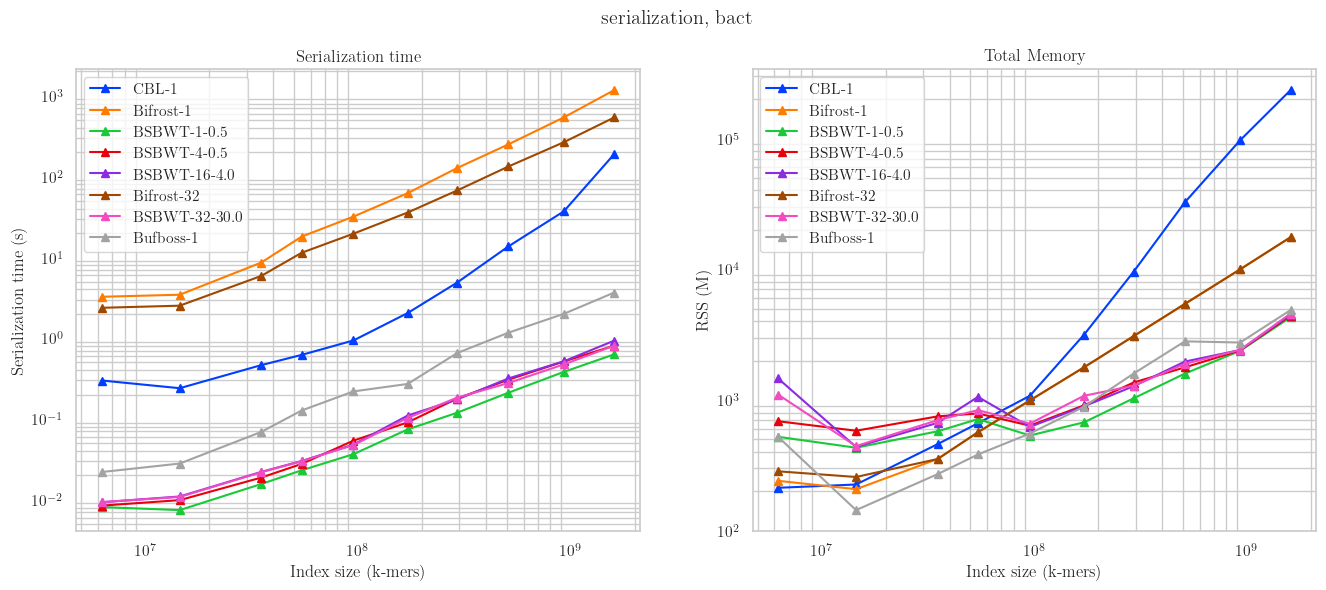

In [44]:
plot_time_and_space(bact_ins, "serialization, bact", "serialization_bact_total.pdf", 4, "Serialization time", False)

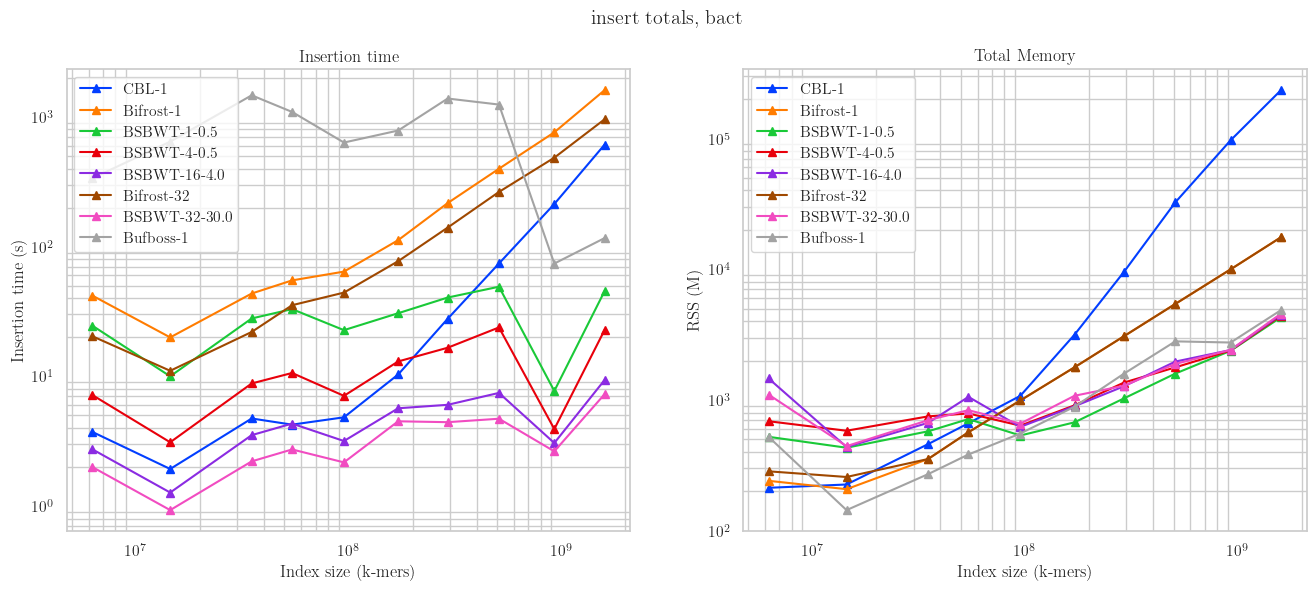

In [45]:
plot_time_and_space(bact_ins, "insert totals, bact", "insert_bact_total.pdf")

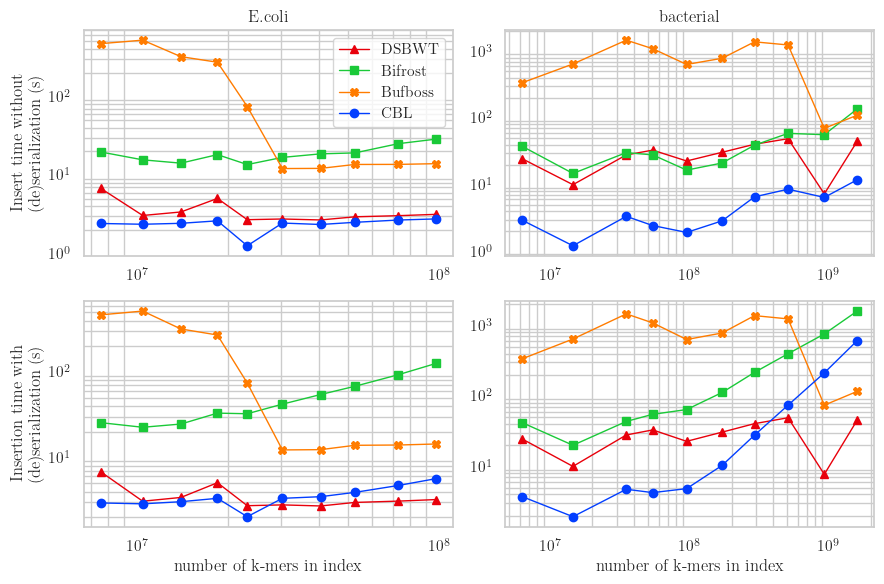

In [46]:
plt.figure(figsize=(9, 6))

for i, (ds, name) in enumerate(zip([coli_ins, bact_ins], ["E.coli", "bacterial"])):
    plt.subplot(2, 2, i + 1)
    handles = []
    for k, v in sorted(ds["data"].items()):
        if "nope" == IO_name_mapping[k]:
            continue
        handles += plt.plot(ds["size"], [vv[3] for vv in v], linewidth=1,
            color=color_mapping[k], label=IO_name_mapping[k], marker=marker_mapping[k]
        )
    plt.yscale("log")
    plt.xscale("log")
    if i == 0:
        plt.ylabel("Insert time without\n(de)serialization (s)")
        plt.legend()
    plt.title(name)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(2, 2, i + 3)
    for k, v in sorted(ds["data"].items()):
        if "nope" == IO_name_mapping[k]:
            continue
        plt.plot(ds["size"], [vv[0] for vv in v], linewidth=1,
             color=color_mapping[k], label=IO_name_mapping[k], marker=marker_mapping[k]
        )
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("number of k-mers in index")
    if i == 0:
        plt.ylabel("Insertion time with\n(de)serialization (s)")
    #plt.legend()
    plt.grid(which='major')
    plt.grid(which='minor')
plt.tight_layout()
plt.savefig("IO_time_and_space_comp.pdf", bbox_inches="tight")
#plt.show()

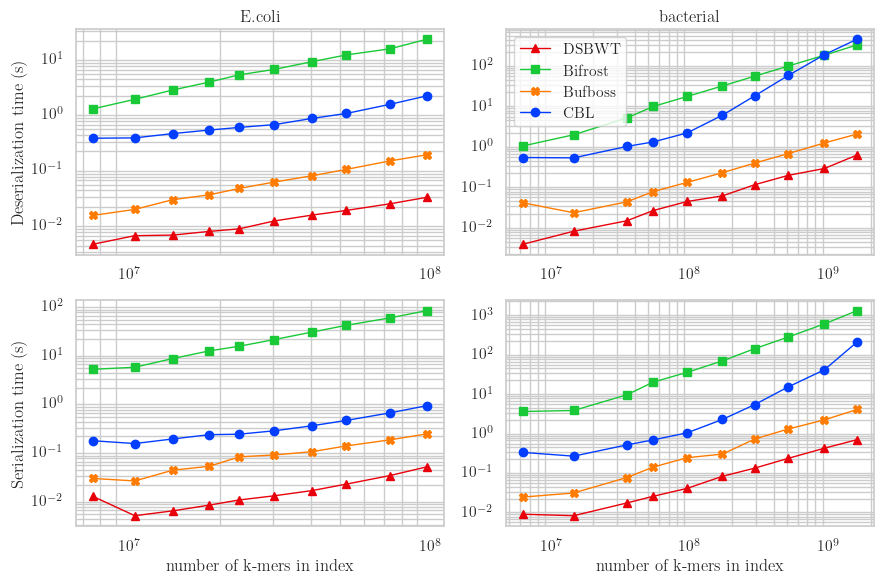

In [47]:
plt.figure(figsize=(9, 6))

for i, (ds, name) in enumerate(zip([coli_ins, bact_ins], ["E.coli", "bacterial"])):
    plt.subplot(2, 2, i + 1)
    handles = []
    for k, v in sorted(ds["data"].items()):
        if "nope" == IO_name_mapping[k]:
            continue
        handles += plt.plot(ds["size"], [vv[2] for vv in v], linewidth=1,
            color=color_mapping[k], label=IO_name_mapping[k], marker=marker_mapping[k]
        )
    plt.yscale("log")
    plt.xscale("log")
    if i == 0:
        plt.ylabel("Deserialization time (s)")
    else:
        plt.legend()
    plt.title(name)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(2, 2, i + 3)
    for k, v in sorted(ds["data"].items()):
        if "nope" == IO_name_mapping[k]:
            continue
        plt.plot(ds["size"], [vv[4] for vv in v], linewidth=1,
             color=color_mapping[k], label=IO_name_mapping[k], marker=marker_mapping[k]
        )
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("number of k-mers in index")
    if i == 0:
        plt.ylabel("Serialization time (s)")
    #plt.legend()
    plt.grid(which='major')
    plt.grid(which='minor')
plt.tight_layout()
plt.savefig("IO_time_and_space.pdf", bbox_inches="tight")
#plt.show()

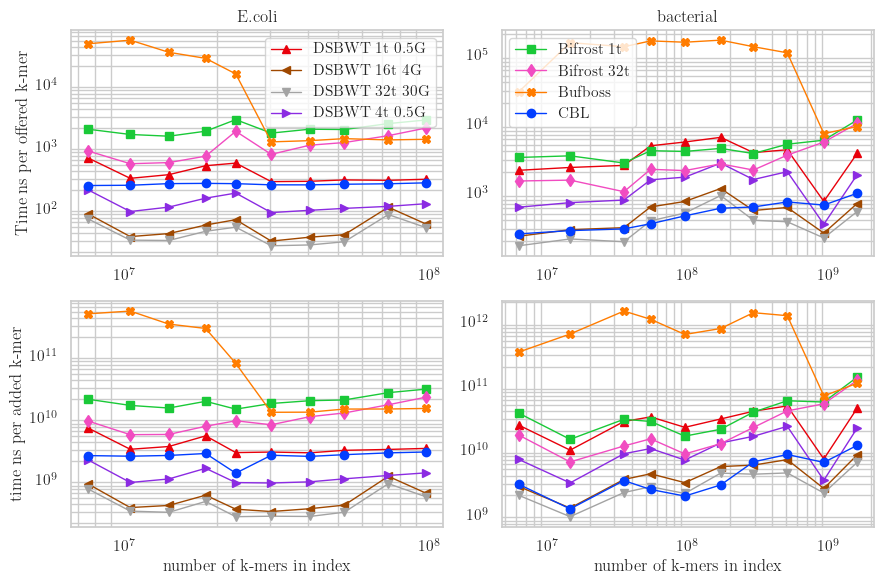

In [48]:
plt.figure(figsize=(9, 6))

for i, (ds, name) in enumerate(zip([coli_ins, bact_ins], ["E.coli", "bacterial"])):
    plt.subplot(2, 2, i + 1)
    handles = []
    for k, v in sorted(ds["data"].items()):
        if "nope" == name_mapping[k]:
            continue
        handles += plt.plot(ds["size"], [vv[3] * 1000**3 / a for vv, a in zip(v, ds["offered"])], linewidth=1,
            color=color_mapping[k], label=name_mapping[k], marker=marker_mapping[k]
        )
    plt.yscale("log")
    plt.xscale("log")
    if i == 0:
        plt.ylabel("Time ns per offered k-mer")
        plt.legend(handles=handles[:4])
    else:
        plt.legend(handles=handles[4:])
    plt.title(name)
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.subplot(2, 2, i + 3)
    for k, v in sorted(ds["data"].items()):
        if "nope" == name_mapping[k]:
            continue
        plt.plot(ds["size"], [vv[3] * 1000**3 for vv, a in zip(v, ds["added"])], linewidth=1,
             color=color_mapping[k], label=name_mapping[k], marker=marker_mapping[k]
        )
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("number of k-mers in index")
    if i == 0:
        plt.ylabel("time ns per added k-mer")
    #plt.legend()
    plt.grid(which='major')
    plt.grid(which='minor')
plt.tight_layout()
plt.savefig("insert_time.pdf", bbox_inches="tight")
#plt.show()

In [55]:
def f_num(val):
    if val < 10:
        return f"{val:.2f}"
    s_val = f"{val:.2E}".split("+")
    return s_val[0][:-1] + "e" + str(int(s_val[1]))

In [52]:
def make_tab(df):
    text = r"\begin{longtable}{ l | "
    text += " | ".join("l" for _ in range(10))
    text += "}\n\\hline\n"
    text += "Index k-mers & "
    text += " & ".join(f_num(v) for v in df["size"])
    text += "\\\\\nOffered k-mers & "
    text += " & ".join(f_num(v) for v in df["offered"])
    text += "\\\\\nAdded k-mers & "
    text += " & ".join(f_num(v) for v in df["added"])
    text += "\\\\\n"
    for l, idx in zip(["Total time (s)", "Load time (s)", "Insert time (s)", "Save time (s)", "RSS (bytes)"], [0, 2, 3, 4, 1]):
        text += "\\hline\n" + l + " &" * 10 + " \\\\\n"
        for k, v in df["data"].items():
            text += f"{name_mapping[k]} & "
            text += " & ".join(f_num(vv[idx]) for vv in v)
            text += " \\\\\n"
    text += "\\hline\n\\end{longtable}\n"
    print(text)

In [53]:
make_tab(coli_ins)

\begin{longtable}{ l | l | l | l | l | l | l | l | l | l | l}
\hline
Index k-mers & 7.55e6 & 1.04e7 & 1.39e7 & 1.84e7 & 2.31e7 & 3.02e7 & 4.04e7 & 5.25e7 & 7.32e7 & 9.75e7\\
Offered k-mers & 1.04e7 & 1.01e7 & 9.75e6 & 1.04e7 & 5.06e6 & 1.03e7 & 9.87e6 & 1.03e7 & 1.08e7 & 1.08e7\\
Added k-mers & 2.86e6 & 9.41e5 & 8.45e5 & 1.10e6 & 4.76e5 & 1.20e5 & 7.08e4 & 6.65e4 & 2.15e4 & 1.33e4\\
\hline
Total time (s) & & & & & & & & & & \\
CBL & 2.94 & 2.87 & 3.04 & 3.33 & 2.03 & 3.33 & 3.48 & 3.91 & 4.71 & 5.66 \\
Bifrost 1t & 2.56e1 & 2.26e1 & 2.47e1 & 3.31e1 & 3.26e1 & 4.22e1 & 5.47e1 & 6.83e1 & 9.34e1 & 1.26e2 \\
DSBWT 1t 0.5G & 6.82 & 3.08 & 3.41 & 5.07 & 2.73 & 2.79 & 2.71 & 2.98 & 3.09 & 3.22 \\
DSBWT 4t 0.5G & 2.09 & 0.90 & 1.03 & 1.53 & 0.91 & 0.89 & 0.94 & 1.05 & 1.20 & 1.33 \\
DSBWT 16t 4G & 0.86 & 0.36 & 0.39 & 0.57 & 0.35 & 0.32 & 0.36 & 0.41 & 1.17 & 0.65 \\
Bifrost 32t & 1.35e1 & 1.07e1 & 1.35e1 & 1.89e1 & 2.32e1 & 2.74e1 & 3.88e1 & 4.92e1 & 6.73e1 & 1.03e2 \\
DSBWT 32t 30G & 0.72 & 

In [54]:
make_tab(bact_ins)

\begin{longtable}{ l | l | l | l | l | l | l | l | l | l | l}
\hline
Index k-mers & 6.24e6 & 1.45e7 & 3.51e7 & 5.43e7 & 9.52e7 & 1.71e8 & 2.93e8 & 5.10e8 & 9.28e8 & 1.60e9\\
Offered k-mers & 1.16e7 & 4.28e6 & 1.12e7 & 6.85e6 & 4.15e6 & 4.80e6 & 1.05e7 & 1.16e7 & 9.69e6 & 1.20e7\\
Added k-mers & 1.16e7 & 4.21e6 & 6.09e6 & 6.67e6 & 4.07e6 & 4.59e6 & 5.62e6 & 6.30e6 & 3.97e5 & 5.13e6\\
\hline
Total time (s) & & & & & & & & & & \\
CBL & 3.73 & 1.93 & 4.73 & 4.24 & 4.83 & 1.03e1 & 2.78e1 & 7.41e1 & 2.13e2 & 6.12e2 \\
Bifrost 1t & 4.20e1 & 1.99e1 & 4.35e1 & 5.49e1 & 6.42e1 & 1.12e2 & 2.17e2 & 3.98e2 & 7.60e2 & 1.61e3 \\
DSBWT 1t 0.5G & 2.46e1 & 1.00e1 & 2.79e1 & 3.30e1 & 2.27e1 & 3.06e1 & 4.05e1 & 4.90e1 & 7.71 & 4.55e1 \\
DSBWT 4t 0.5G & 7.18 & 3.10 & 8.81 & 1.06e1 & 7.07 & 1.30e1 & 1.66e1 & 2.38e1 & 3.92 & 2.28e1 \\
DSBWT 16t 4G & 2.74 & 1.27 & 3.52 & 4.32 & 3.17 & 5.67 & 6.03 & 7.45 & 3.06 & 9.38 \\
Bifrost 32t & 2.04e1 & 1.10e1 & 2.20e1 & 3.53e1 & 4.42e1 & 7.72e1 & 1.40e2 & 2.64e2 & 4.85